# Number translation using RNN's (Encoder-Decoder with attention)

In [17]:
from __future__ import print_function
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np
from utils import tokenize
from utils import build_vocabulary_token
from utils import vectorize_corpus
from utils import to_sentence
import csv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [18]:
fr_train=np.load('data_npy/fr_train.npy')
num_train=np.load('data_npy/num_train.npy')
rev_shared_vocab=np.load('data_npy/rev_shared_vocab.npy')
fr_val=np.load('data_npy/fr_val.npy')
num_val=np.load('data_npy/num_val.npy')
fr_test=np.load('data_npy/fr_test.npy')
num_test=np.load('data_npy/num_test.npy')


In [19]:
# Create the shared dictionary
tokenized_fr_train = [tokenize(s, word_level=True) for s in fr_train]
tokenized_num_train = [tokenize(s, word_level=False) for s in num_train]
shared_vocab, rev_shared_vocab = build_vocabulary_token(tokenized_fr_train+tokenized_num_train)

Affichons le dictionnaire bilingue utilisé lors du projet

In [20]:
rev_shared_vocab

['_PAD',
 '_GO',
 '_EOS',
 '_UNK',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'cent',
 'cents',
 'cinq',
 'cinquante',
 'deux',
 'dix',
 'douze',
 'et',
 'huit',
 'mille',
 'neuf',
 'onze',
 'quarante',
 'quatorze',
 'quatre',
 'quinze',
 'seize',
 'sept',
 'six',
 'soixante',
 'treize',
 'trente',
 'trois',
 'un',
 'vingt',
 'vingts']

In [21]:
# Create the training, evaluating and testing sets -> vectorize_corpus mainly applies tokenization
X_train, Y_train = vectorize_corpus(fr_train, num_train, shared_vocab,word_level_target=False)
X_val, Y_val = vectorize_corpus(fr_val, num_val, shared_vocab,word_level_target=False)
X_test, Y_test = vectorize_corpus(fr_test, num_test, shared_vocab,word_level_target=False)

In [24]:
pairs = [(torch.tensor(X_train[i], dtype=torch.long, device=device).view(-1, 1)
,torch.tensor(Y_train[i], dtype=torch.long, device=device).view(-1, 1)) for i in range(num_train.shape[0])]

eval_pairs=[(torch.tensor(X_val[i], dtype=torch.long, device=device).view(-1, 1)
,torch.tensor(Y_val[i], dtype=torch.long, device=device).view(-1, 1)) for i in range(num_val.shape[0])]

test_pairs=[(torch.tensor(X_test[i], dtype=torch.long, device=device).view(-1, 1)
,torch.tensor(Y_test[i], dtype=torch.long, device=device).view(-1, 1)) for i in range(num_test.shape[0])]

Voici un exemple de pair d'entrainement utilisée

In [25]:
pairs[0][0], pairs[0][1]

(tensor([[18],
         [14],
         [28],
         [23],
         [24],
         [14],
         [38],
         [18],
         [ 2],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0]]), tensor([[ 6],
         [ 4],
         [ 8],
         [13],
         [ 6],
         [ 6],
         [ 2],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0]]))

In [26]:
#Here are the parameters we use
MAX_LENGTH = 20
vocab_size = len(shared_vocab)
batch_size=32

GO_token = 1
EOS_token = 2

config ={
        'dropout': 0.2,
        'vocab_size': vocab_size,
        'num_layers': 1,
        'embsize': 32,
        'dim_recurrent': 256,
        'batch_size':batch_size
    }

# Architecture 

## L'Encoder

L'encoder d'un réseau seq2seq est un RNN qui renvoie une valeur pour chaque mot de l'input. Pour chaque mot de l'input, l'encoder renvoie un vecteur et un hidden state, qu'il utilise ensuite pour le mot suivant.


In [27]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.param = [input_size,hidden_size]
        self.embedding = nn.Embedding(input_size,hidden_size)#(self.input_size, self.hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        #input2 = torch.tensor(input)
        #print('avant call', input.dtype)
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Le Decoder

Le decoder est un autre RNN qui prend les vecteurs de sortie de l'encoder et renvoie une liste de chiffres qui correspond à la traduction finale.

### Attention

L'attention permet au decoder, à chaque étape où le decoder renvoie ses outputs, de se concentrer sur une partie différente de la sortie de l'encoder. D'abord on calcule une liste de poids d'attention. On multiplie les vecteurs de sorties de l'encoder par ce vecteur de poids. Le resultat est un vecteur qui contient seulement l'information interessante sur laquelle on souhaite que le decoder se concentre.

Pour calculer les poids d'attention, on utilise un couche de neurone attn, qui utilise comme input l'input du decoder et le hidden state.
On choisit un vector de poids de taille 20, la taille maximale de nos inputs et outputs.

In [28]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        #Generate attention weigths 
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        #Multiply the vector of weigths with the encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Training functions

Pour le training, on passe l'input dans l'encoder et on memorise chaque sortie et le dernier hidden state.
Ensuite on donne au decoder le token <GO> comme 1er input du decoder et le dernier hidden state comme 1er hidden state.

In [29]:
teacher_forcing_ratio = 0.5
#Teaching forcing : on utilise a chaque la sortie reelle (vraie traduction) à chaque fois que le decodeur change de mot, au lieu d'utiliser l'estimation du decodeur sur le mot précédent. 


In [30]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[GO_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [31]:
#Evaluer la qualité de la prédiction
def evaluate(test_pair, encoder, decoder, criterion, max_length=MAX_LENGTH):
    
    input_tensor=test_pair[0]
    target_tensor=test_pair[1]

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    with torch.no_grad():

        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

        loss2 = 0

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[GO_token]])

        decoder_hidden = encoder_hidden

        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss2 += criterion(decoder_output, target_tensor[di])

            if decoder_input.item() == EOS_token:
                break

    return loss2.item() / target_length

In [32]:
#On appelle la fonction train plusieurs fois et on affiche le progrès
def trainIters(encoder, decoder, n_iters,epochs=5, print_every=100, plot_every=100, learning_rate=0.01,n_evaluate=1000):
 
    all_losses=[]
    all_test_losses=[]

    start = time.time()
    print_loss_total = 0.  # Reset every print_every
    plot_loss_total = 0. # Reset every plot_every


    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [random.choice(pairs)for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for epoch in range(0,epochs):

        for iter in range(1, n_iters + 1):
            training_pair = training_pairs[iter - 1]
            input_tensor = torch.tensor(training_pair[0])
            target_tensor = torch.tensor(training_pair[1])

            loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss

            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print("epoch :" + str(epoch) + " iter : " + str(iter))
                print( print_loss_avg)


            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_loss_total = 0.
                all_losses+=[plot_loss_avg]

                test_loss=0.
                for i in range(n_evaluate):
                    test_loss+=evaluate(eval_pair=eval_pairs[i],encoder=encoder, decoder=decoder, criterion=criterion, max_length=MAX_LENGTH)
                all_test_losses+=[test_loss/n_evaluate]


        loss_PATH="losses_epoch"+str(epoch)
        loss_test_PATH="losses_test_epoch"+str(epoch)
        np.save(loss_PATH,np.array(all_losses))
        np.save(loss_test_PATH,np.array(all_test_losses))

        enco_PATH="encoder_epoch"+str(epoch)
        deco_PATH="decoder_epoch"+str(epoch)
        torch.save(encoder,enco_PATH)
        torch.save(encoder,deco_PATH)

    torch.save(encoder,"second_enco")
    torch.save(encoder,"second_deco")       
    np.save('all_losses',np.array(all_losses))
    np.save('all_test_losses',np.array(all_losses))

# Training and Evaluation

The following cell allows to train the model

In [19]:
hidden_size = 256
encoder1 = EncoderRNN(config['vocab_size'], hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, config['vocab_size'], dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, n_iters=20000,epochs=10, print_every=100,plot_every=10)

/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch :0 iter : 100
0.8553461551666257
epoch :0 iter : 200
0.6740361294746396
epoch :0 iter : 300
0.689356122493744
epoch :0 iter : 400
0.6777678551673888
epoch :0 iter : 500
0.6824280066490176
epoch :0 iter : 600
0.6665150694847106
epoch :0 iter : 700
0.6553200592994692
epoch :0 iter : 800
0.6632100200653076
epoch :0 iter : 900
0.6459337892532347
epoch :0 iter : 1000
0.6473236408233644
epoch :0 iter : 1100
0.655437062740326
epoch :0 iter : 1200
0.6296192998886108
epoch :0 iter : 1300
0.6371200051307679
epoch :0 iter : 1400
0.6386592783927919
epoch :0 iter : 1500
0.6393913276195525
epoch :0 iter : 1600
0.6390984573364258
epoch :0 iter : 1700
0.6271481351852419
epoch :0 iter : 1800
0.6050196166038512
epoch :0 iter : 1900
0.5333645849227908
epoch :0 iter : 2000
0.5013874466419221


KeyboardInterrupt: 

## Plot
Here are the losses we got when we trained our model

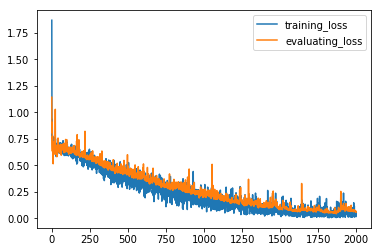

In [33]:

loss1 = np.load('result/losses.npy')
loss2 =np.load('result/losses_test.npy')

plt.figure()
plt.plot(loss1, label='training_loss')
plt.plot(loss2, label='evaluating_loss')
plt.legend()


plt.show()

# Model testing

After training, we want to test whether our model is able to provide correct translation. We test it with de testing dataset.

We introduce a function decode that take a tokenized sentence of words and translates it into figures.

In [34]:
#Decode la solution pour chaque input
def decode(input_tensor,encoder,decoder):

    max_length=MAX_LENGTH
    input_length = input_tensor.size(0)
    target_length = MAX_LENGTH

    encoder_hidden = encoder.initHidden()
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[GO_token]], device=device)
    decoder_hidden = encoder_hidden

    solu=torch.zeros(max_length)

    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()
        solu[di]=decoder_input


    return solu

In [35]:
our_encoder=torch.load('saved_models/first_enco.pt')
our_decoder=torch.load('saved_models/first_deco.pt')

/Users/MathieuRita/Desktop/TensorFlow/lib/python2.7/site-packages/torch/serialization.py:400: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/Users/MathieuRita/Desktop/TensorFlow/lib/python2.7/site-packages/torch/serialization.py:400: UserWarning: Couldn't retrieve source code for container of type AttnDecoderRNN. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


In [46]:
for i in range(20):
    print("Test " + str(i))
    randind=np.random.randint(0,len(fr_test))
    print("input :", fr_test[randind])
    print("correct answer : ", to_sentence(test_pairs[randind][1],rev_shared_vocab))
    print("prediction :", to_sentence(decode(input_tensor=test_pairs[randind][0],encoder=our_encoder,decoder=our_decoder),rev_shared_vocab))
    

Test 0
input : quatre vingt dix neuf mille cinq cent dix huit
correct answer :  99518
prediction : 99518
Test 1
input : cinq cent cinquante cinq mille cinq cent quarante six
correct answer :  555546
prediction : 555546
Test 2
input : trois cent vingt deux mille cinq cent quatre vingt huit
correct answer :  322588
prediction : 322588
Test 3
input : mille neuf cent vingt et un
correct answer :  1921
prediction : 1921
Test 4
input : trois cent soixante douze mille dix sept
correct answer :  372017
prediction : 372017
Test 5
input : cinquante neuf mille cent soixante deux
correct answer :  59162
prediction : 59162
Test 6
input : vingt mille quatre cent quatre
correct answer :  20404
prediction : 20404
Test 7
input : vingt neuf mille deux
correct answer :  29002
prediction : 29002
Test 8
input : cinq cent trente huit mille cent soixante sept
correct answer :  538167
prediction : 538167
Test 9
input : six cent dix sept mille six cent quatre vingt trois
correct answer :  617683
prediction : 6

We now want to evaluate our model by computing an evaluation score.
We just compute the percentage of correct predictions over the testing set.

In [51]:
score=0.
for i in range(1000):
    randind=np.random.randint(0,len(fr_test))
    pred=to_sentence(decode(input_tensor=test_pairs[randind][0],encoder=our_encoder,decoder=our_decoder),rev_shared_vocab)
    if int(num_test[randind])==int(pred):
        score+=1
print(score/1000.)

0.982


# Conclusion

We see that with we provided a model that is able to solve this translation problem for round 98% of the cases. As a comparison, we wanted to beat the score of a simple encoder-decoder architecture that was able to solve this problem in 44% of the cases.